<div align="center">
    <h1>Υπολογιστική Γεωμετρία (Εργασία) - Γεωμετρική Αναζήτηση</h1>
</div>

Σε αυτό το notebook θα ασχοληθούμε με το δεύτερο μέρος της εργασίας το οποίο αφορά το **Γεωμετρική Αναζήτηση**. Συγκεκριμένα θα υλοποιήσουμε δύο αλγορίθμους που αφορούν τη δομή δεδομένων **kd tree**. Θα υλοποιήσουμε έναν **αλγόριθμο κατασκευής** μίας τέτοιας δομής και έναν **αλγόριθμο αναζήτησης** πάνω σε αυτή. 

In [1]:
from matplotlib import pyplot as plt

# Change this according to your theme. 
# For dark theme use 'dark_background'
# For light theme use 'default'
plots_theme = "default"

plt.style.use(plots_theme)
grid_color = "#373737" if plots_theme == 'dark_background' else "#CDCDCD"

Αρχικά θα αρχικοποιήσουμε μερικές βοηθητικές δομές για τους αλγορίθμους μας. Πιο συγκεκριμένα θα ορίσουμε τη κλάση για το **σημείο στο επίπεδο** και δύο κλάσεις που θα αφορούν τη δομή του δένδρου, τον **εσωτερικό κόμβο** και τον **κόμβο φύλλο**. 

In [2]:
class Vector2D:
  def __init__(self, x: float, y: float):
    self.x = x
    self.y = y

  def __repr__(self):
    return f"({self.x:.2f}, {self.y:.2f})"
  

class KD_LeafNode:
  def __init__(self, point: Vector2D):
    self.point = point
    
  def __repr__(self):
    return f"{self.point}"

class KD_InnerNode:
  def __init__(self, median_value: float, left, right):
    self.median = median_value
    self.left = left
    self.right = right
    
  def get_leaf_nodes(self):
    leaf_nodes = []
    def dfs(node):
      if isinstance(node, KD_LeafNode):
        leaf_nodes.append(node)
      else:
        dfs(node.left)
        dfs(node.right)
        
    dfs(self)
    return leaf_nodes
    
  def __repr__(self):
    return f"Median: {self.median:.2f}"

Θα ορίσουμε επίσης μία κλάση που θα αναπαριστά την **ορθογώνια έκταση** στο επίπεδο. Αυτή η κλάση θα μας φανεί χρήσιμη στην διαδικασία της αναζήτησης πάνω στη δομή του δένδρου.

In [3]:
import numpy as np

class Area:
  def construct(self, P: np.ndarray[Vector2D]):
    self.x_min = min(P, key=lambda p: p.x).x
    self.x_max = max(P, key=lambda p: p.x).x
    self.y_min = min(P, key=lambda p: p.y).y
    self.y_max = max(P, key=lambda p: p.y).y
    self.points = P
    
  def __init__(self, x_min: float=None, x_max: float=None, y_min: float=None, y_max: float=None):
    self.x_min = x_min
    self.x_max = x_max
    self.y_min = y_min
    self.y_max = y_max
    self.points = None
    
  def contains_point(self, point: Vector2D) -> bool:
    return self.x_min <= point.x <= self.x_max and self.y_min <= point.y <= self.y_max
  
  def contains_area(self, area) -> bool:
    return self.x_min <= area.x_min and self.x_max >= area.x_max and self.y_min <= area.y_min and self.y_max >= area.y_max
    
  def __repr__(self):
    return f"X: [{self.x_min:.2f}, {self.x_max:.2f}], Y: [{self.y_min:.2f}, {self.y_max:.2f}]"

Τέλος θα κατασκευάσουμε τη γενική κλάση της δομής δεδομένων **kd tree** και θα ορίσουμε τους αλγορίθμους **κατασκευής** και **αναζήτησης** στο εσωτερικό της κλάσης ως μεθόδους **build** και **search** αντίστοιχα.

In [4]:
import numpy as np
import typing
from matplotlib import pyplot as plt
import io
from PIL import Image

class KD_Tree:
  def __init__(self, P: np.ndarray[Vector2D]):
    self.P = P
    self.root = None
    self.plots = []
    self.previous_lines = []

  def __build(self, P, depth, x_min, x_max, y_min, y_max, render_mode: bool = False):
    if len(P) == 1:
      return KD_LeafNode(P[0])

    median = len(P) // 2

    if depth % 2 == 0:  # Vertical split
      P = sorted(P, key=lambda p: p.x)
      P1, P2 = P[:median], P[median:]

      # Get new split line and update boundaries
      x_split = P[median].x
      if render_mode:
        self.__plot_split(P, x_split, 'vertical', x_min, x_max, y_min, y_max)

      # Left subtree: x_max is updated to split position
      v_left = self.__build(P1, depth + 1, x_min, x_split, y_min, y_max, render_mode)
      # Right subtree: x_min is updated to split position
      v_right = self.__build(P2, depth + 1, x_split, x_max, y_min, y_max, render_mode)

      return KD_InnerNode(x_split, v_left, v_right)

    else:  # Horizontal split
      P = sorted(P, key=lambda p: p.y)
      P1, P2 = P[:median], P[median:]

      y_split = P[median].y
      if render_mode:
        self.__plot_split(P, y_split, 'horizontal', x_min, x_max, y_min, y_max)

      # Bottom subtree: y_max is updated to split position
      v_left = self.__build(P1, depth + 1, x_min, x_max, y_min, y_split, render_mode)
      # Top subtree: y_min is updated to split position
      v_right = self.__build(P2, depth + 1, x_min, x_max, y_split, y_max, render_mode)

      return KD_InnerNode(y_split, v_left, v_right)


  def __plot_split(self, P, value, orientation, x_min, x_max, y_min, y_max):
    fig, ax = plt.subplots()
    ax.scatter([p.x for p in self.P], [p.y for p in self.P], color='#339AFF', label="Points")

    # Draw previous lines
    for (line, orient, x_min_prev, x_max_prev, y_min_prev, y_max_prev) in self.previous_lines:
      if orient == 'vertical':
        ax.plot([line, line], [y_min_prev, y_max_prev], color='#DC3131', linestyle='--', label='Split Line')
      elif orient == 'horizontal':
        ax.plot([x_min_prev, x_max_prev], [line, line], color='#DC3131', linestyle='--', label='Split Line')

    # Draw the current line with constrained limits
    if orientation == 'vertical':
      ax.plot([value, value], [y_min, y_max], color='#2E9110', linestyle='--', label='Split Line')
    elif orientation == 'horizontal':
      ax.plot([x_min, x_max], [value, value], color='#2E9110', linestyle='--', label='Split Line')

    # Store the current split
    self.previous_lines.append((value, orientation, x_min, x_max, y_min, y_max))

    ax.set_title(f"Bulding process of the KD-Tree (Step {len(self.previous_lines)})")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    
    ax.grid(color=grid_color)
    
    buf = io.BytesIO()
    plt.tight_layout()
    plt.savefig(buf, format='png', bbox_inches='tight')
    plt.close(fig)
    self.plots.append(Image.open(buf))


  def build(self, render_steps: bool = False):
    self.previous_lines = []
    
    # Find min and max x and y values
    x_min, x_max = min(p.x for p in self.P), max(p.x for p in self.P)
    y_min, y_max = min(p.y for p in self.P), max(p.y for p in self.P)

    # Start building the KD-tree
    self.root = self.__build(self.P, 0, x_min, x_max, y_min, y_max, render_steps)


  def search(self, root, search_area: Area, depth: int = 0):
    v = root
    final_points = set()

    # Check if there is only one point in the tree
    if isinstance(v, KD_LeafNode):
      if search_area.contains_point(v.point):
        final_points.add(v.point)

    # Check if the left or down subtree is in the search area or not
    else:
      # Get the left and right areas
      left_area, right_area = Area(), Area()
      left_area.construct([node.point for node in v.left.get_leaf_nodes()] if isinstance(v.left, KD_InnerNode) else [v.left.point])
      right_area.construct([node.point for node in v.right.get_leaf_nodes()] if isinstance(v.right, KD_InnerNode) else [v.right.point])

      # Check if the search area contains the left area
      if search_area.contains_area(left_area):
        final_points.update(left_area.points)
      else:
        final_points.update(self.search(v.left, search_area, depth + 1))

      # Check if the search area contains the right area
      if search_area.contains_area(right_area):
        final_points.update(right_area.points)
      else:
        final_points.update(self.search(v.right, search_area, depth + 1))

    return final_points

  def render_plots(self):
    num_plots = len(self.plots)
    if num_plots == 0:
        return
    cols = 3  # Number of columns in the grid
    rows = (num_plots // cols) + (num_plots % cols > 0)  # Compute required rows

    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(30, len(self.plots) * 3))
    
    # Flatten axes array for easier indexing
    axes = axes.flatten()

    for i, ax in enumerate(axes):
      if i < num_plots:  
        ax.imshow(self.plots[i])
        ax.axis('off')
      else:
        ax.set_visible(False)  # Hide empty subplots

    plt.tight_layout()
    plt.show()


  def __repr__(self):
    output = ""
    def dfs(node, depth):
      nonlocal output
      if isinstance(node, KD_LeafNode):
        output += "  " * depth + f"{node}\n"
      else:
        output += "  " * depth + f"{node}\n"
        dfs(node.left, depth + 1)
        dfs(node.right, depth + 1)

    dfs(self.root, 0)
    return output

Ας ορίσουμε μερικά σημεία στο επίπεδο και ας παρατηρήσουμε τη κατασκευή ενός kd δένδρου με αυτά τα δεδομένα σημεία.

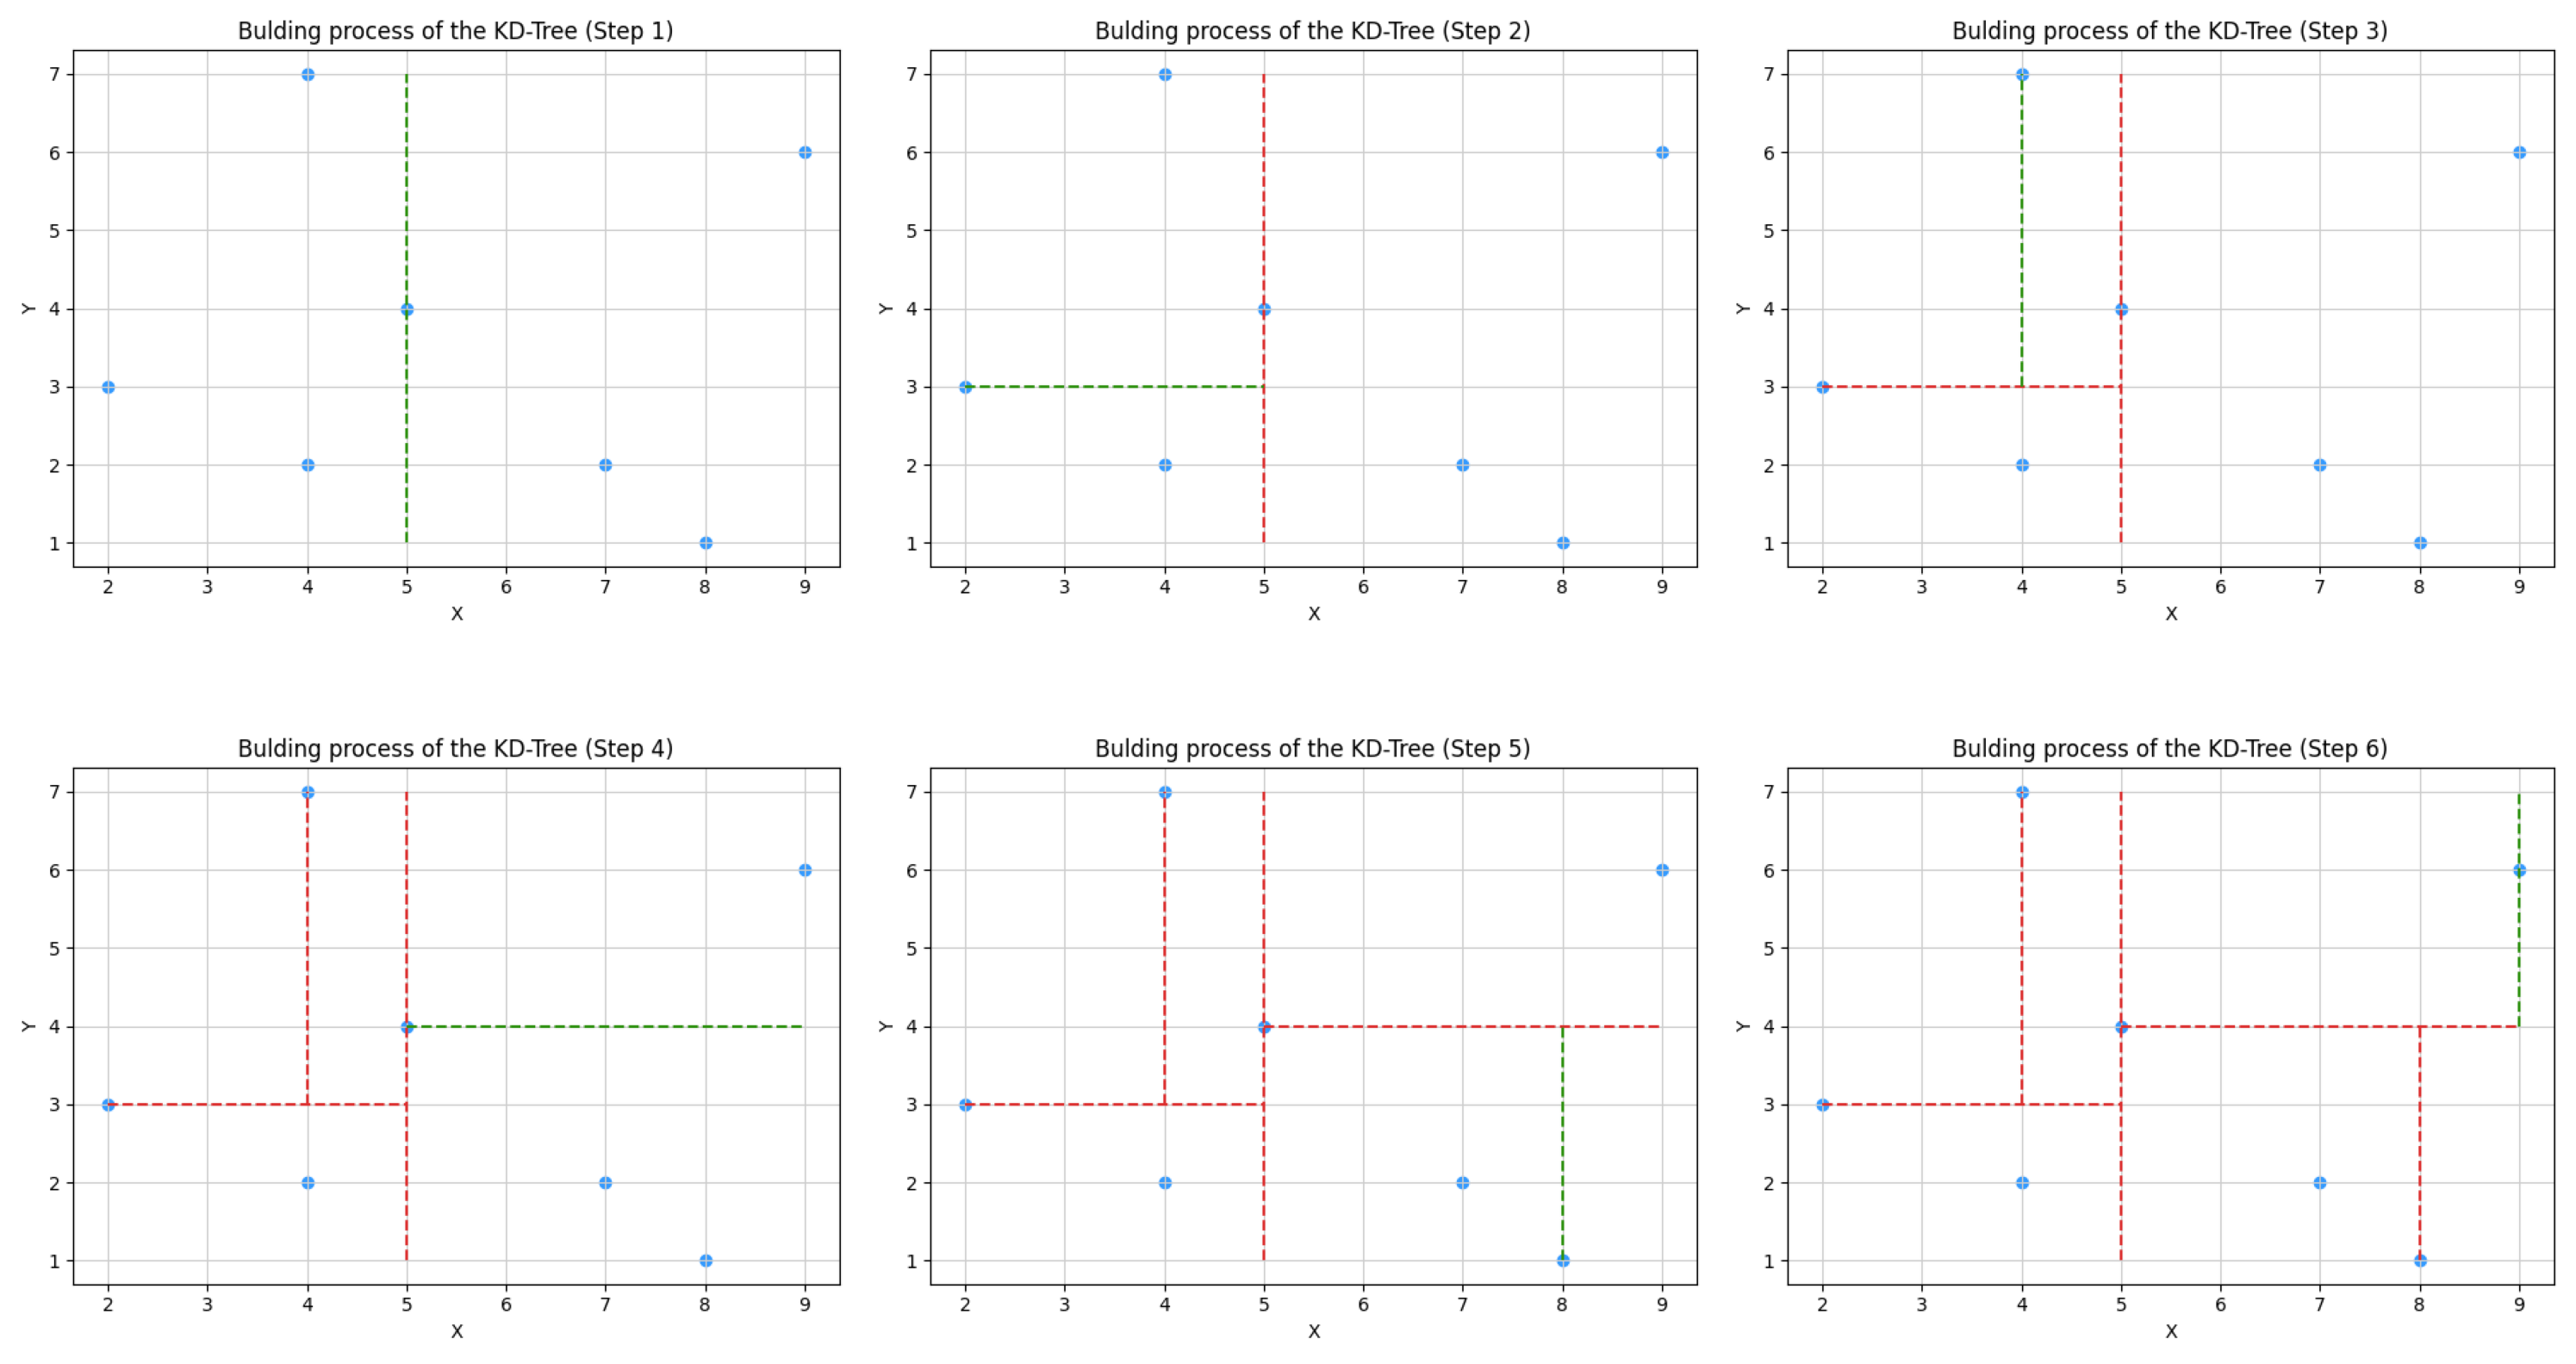

In [5]:
import matplotlib.pyplot as plt

# Create a set of points
P = np.array([
  Vector2D(2, 3),
  Vector2D(5, 4),
  Vector2D(9, 6),
  Vector2D(4, 7),
  Vector2D(8, 1),
  Vector2D(7, 2),
  Vector2D(4, 2)
])

# Create a KD-Tree
kd_tree = KD_Tree(P)
kd_tree.build(render_steps=True)

# Plot the KD-Tree building process
kd_tree.render_plots()


Τέλος ας δημιουργήσουμε ένα σύνολο **150 τυχαίων σημείων** στο επίπεδο και ας δημιουργήσουμε ένα kd δένδρο χρησιμοποιώντας αυτά τα σημεία. Ας ορίσουμε επίσης μία **ορθογώνια έκταση** πάνω στην οποία θα γίνει αναζήτηση σημείων στο δένδρο και ας οπτικοποιήσουμε το αποτέλεσμα.

{(43.42, 65.08), (10.28, 37.08), (39.98, 61.83), (20.18, 48.66), (43.40, 67.59), (40.80, 45.15), (34.39, 65.10), (14.34, 55.48), (34.16, 58.42), (32.14, 43.77), (43.77, 47.43), (20.02, 49.25), (38.67, 38.76), (34.59, 58.47), (32.33, 68.87), (10.93, 56.69), (22.20, 44.53), (41.26, 60.73), (10.48, 57.26), (11.07, 47.90), (23.97, 37.05)}


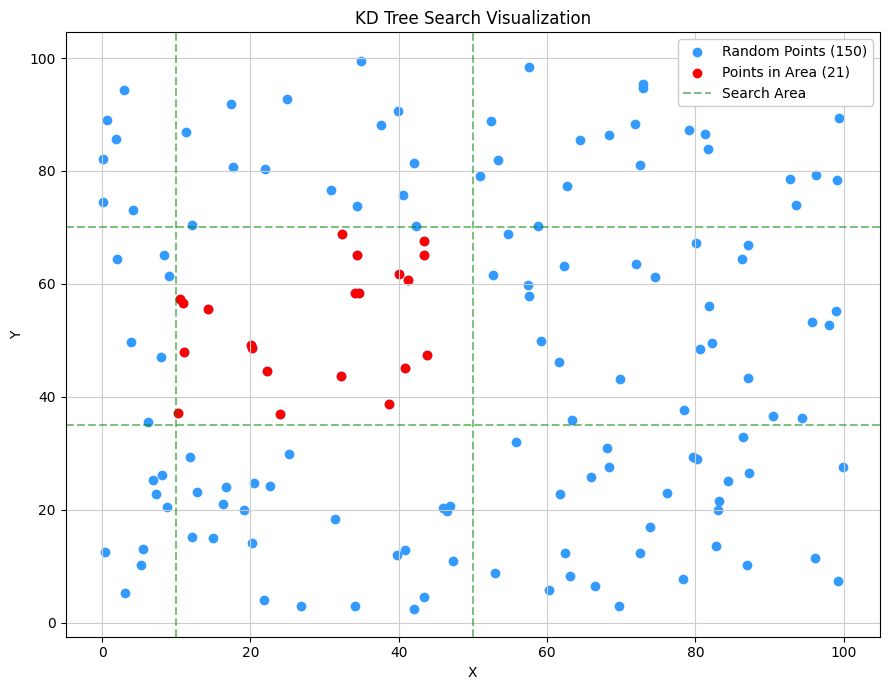

In [6]:
# Create a set of 150 random points
P = np.array([Vector2D(np.random.uniform(0, 100), np.random.uniform(0, 100)) for _ in range(150)])

# Create a KD Tree using the above points and build it
kd_tree = KD_Tree(P)
kd_tree.build()

# Search for points in the area [10, 50] x [35, 70]
search_area = Area(10, 50, 35, 70)
points = kd_tree.search(kd_tree.root, search_area)
print(points)

# Plot the points
plt.figure(figsize=(9, 7))
plt.scatter([p.x for p in P], [p.y for p in P], color='#339AFF', label=f"Random Points ({len(P)})")
plt.scatter([p.x for p in points], [p.y for p in points], color='red', label=f"Points in Area ({len(points)})")

# Plot the vertical and horizontal lines of the search area
plt.axvline(x=search_area.x_min, color='green', linestyle='--', alpha=0.5, label="Search Area")
plt.axvline(x=search_area.x_max, color='green', linestyle='--', alpha=0.5)
plt.axhline(y=search_area.y_min, color='green', linestyle='--', alpha=0.5)
plt.axhline(y=search_area.y_max, color='green', linestyle='--', alpha=0.5)

plt.grid(color=grid_color)

plt.title("KD Tree Search Visualization")
plt.xlabel("X")
plt.ylabel("Y")

plt.legend(framealpha=1.0, loc="upper right")
plt.tight_layout()
plt.show()

Στο παραπάνω διάγραμμα τα **μπλε σημεία** αποτελούν τα τυχαία σημεία στο επίπεδο και τα **κόκκινα σημεία** αποτελούν το αποτέλεσμα της **γεωμετρικής αναζήτησης** σε αυτό το σύνολο σημείων που βρίσκονται μέσα στη γεωμετρική έκταση που ορίζουν οι **πράσινες διακεκομένες ευθείες**.